Tutorial 1: Global Models
=========================

In chapter 1, we primarily focused on fitting one model to one dataset. We have inspected the results of those
individual model-fits using tools such as the `Aggregator` and demonstrated that when necessary we are able to fit
more complex models, for example 1D profiles composed of 2 or 3 Gaussians / Exponentials.

However, for many problems we may have a large dataset, and we are not particularly interested in how well the model
fits each dataset individually. Instead, we wish to fit this model (or many similar models) to the full
dataset and determine the 'global' trends of the model across the dataset.

In this chapter we demonstrate how this can be done using graphical models, which not only fit the model to each
individual dataset but simultaneously compose and fit higher-level model components that seek to capture global trends
of the model across the data.

To take a real world example, in a healthcare setting we are not interested in whether a treatment successfully helps
an individual patient recover. We can only claim that a treatment is truly effective if it successfully helps a
large sample of patients to show a higher chance of recover. Medical datasets may contain data on thousands of patients
which each need modeled individually to determine these global trends. Using the methods of chapter 1 this require us
to fit models with thousands of parameters, which is computationally unfeasiable. Graphical models provide us with a
means to break this fitting procedure down into a computationally tractable problem.

In this tutorial, we will demonstrate the problem using our toy model of fitting noisy 1D datasets. We use a dataset
containing 3 noisy 1D Gaussians and we will suppose that we *know* that all 3 Gaussians have the same `centre`,
which we term the global `centre` value in our full dataset that we seek to estimate.

The datasets fitted in this tutorial are much lower signal-to-noise than those fitted in chapter 1 and there will be a
large uncertainty on the value of `centre` in an individual model-fit. In this tutorial we will consider attempt to
estimate the global `centre` without using a graphical model.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
from os import path
import numpy as np
import matplotlib.pyplot as plt
import os

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


We'll use the `Analysis` class of chapter 1, which includes `visualize` and `save_attributes_for_aggregator` methods.

In [2]:
from analysis import Analysis

We'll fit a single Gaussian as our model.

In [3]:
import profiles as p

model = af.CollectionPriorModel(gaussian=p.Gaussian)

To perform visualization we'll plot the 1D data as a line. 

To facilitate this we define the function `plot_line` below, which uses Matplotlib to create the 1D plots we've seen 
in previous tutorials. This function has additional inputs so the plot can be output to a specified output path with a 
given output file name.

In [4]:
def plot_line(xvalues, line, title=None, ylabel=None, errors=None, color="k"):
    """
    Plot a 1D line of data on a plot of x versus y, where the x-axis is the x coordinate of the line and the y-axis
    is the intensity of the line at that coordinate.

    The function include options to output the image to the hard-disk as a .png.

    Parameters
    ----------
    xvalues : np.ndarray
        The x-coordinates the profile is defined on.
    line : np.ndarray
        The intensity values of the profile which are plotted.
    ylabel : str
        The y-label of the plot.
    """
    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title(title)
    plt.xlabel("x value of profile")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()


For each dataset we now set up the correct path, load it, and plot it, to show how low signal-to-noise it is!

fit it using a `NonLinearSearch`, as we did in 
tutorial 7 of chapter 1.

In [5]:
dataset_names = [
    "gaussian_x1_0__low_snr",
    "gaussian_x1_1__low_snr",
    "gaussian_x1_2__low_snr",
]

This for loop runs over every dataset, checkout the comments below for how we set up the path structure.

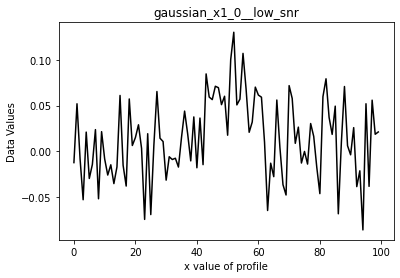

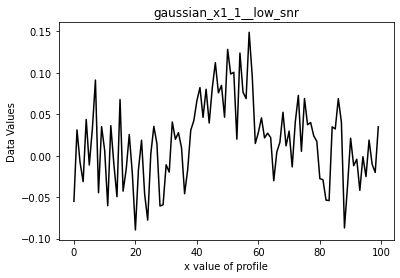

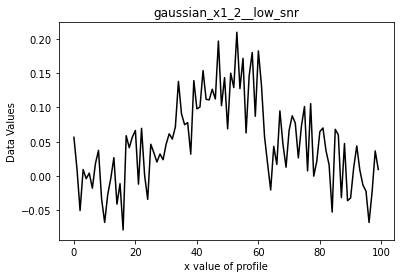

<Figure size 432x288 with 0 Axes>

In [6]:
for dataset_name in dataset_names:

    """Load the dataset from the `autofit_workspace/dataset` folder."""
    dataset_path = path.join("dataset", "example_1d", dataset_name)

    data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
    noise_map = af.util.numpy_array_from_json(
        file_path=path.join(dataset_path, "noise_map.json")
    )

    plot_line(
        xvalues=np.arange(data.shape[0]),
        line=data,
        title=dataset_name,
        ylabel="Data Values",
        color="k",
    )

For every dataset we now create an `Analysis` class using it and use `Emcee` to fit it with a `Gaussian`.

In [7]:
for dataset_name in dataset_names:

    """Load the dataset from the `autofit_workspace/dataset` folder."""
    dataset_path = path.join("dataset", "example_1d", dataset_name)

    data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
    noise_map = af.util.numpy_array_from_json(
        file_path=path.join(dataset_path, "noise_map.json")
    )

    """Create the `DynestyStatic` `NonLinearSearch` and use it to fit the data."""
    analysis = Analysis(data=data, noise_map=noise_map)

    emcee = af.DynestyStatic(
        name=dataset_name,
        path_prefix=path.join(
            "howtofit", "tutorial_1_global_model"
        ),
    )

    print(
        f"Emcee has begun running, checkout \n"
        f"autofit_workspace/output/howtofit/chapter_graphica_models/tutorial_1_global_model/{dataset_name} for live \n"
        f"output of the results. This Jupyter notebook cell with progress once Emcee has completed, this could take a \n"
        f"few minutes!"
    )

    emcee.fit(model=model, analysis=analysis)


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 655.41it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < 169.311 <    inf | logz: 165.769 +/- 29.583 | dlogz:  0.501 >  0.059]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).


Emcee has begun running, checkout 
autofit_workspace/output/howtofit/chapter_graphica_models/tutorial_1_global_model/gaussian_x1_0__low_snr for live 
output of the results. This Jupyter notebook cell with progress once Emcee has completed, this could take a 
few minutes!
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png


INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__

INFO:root:15000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 712.23it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < 150.191 <    inf | logz: 145.923 +/-    nan | dlogz:  0.852 >  0.059]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_0__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
Emcee has begun running, checkout 
autofit_workspace/output/howtofit/chapter_graphica_models/tutorial_1_global_model/gaussian_x1_1__low_snr for live 
output of the results. This Jupyter notebook cell with progress once Emcee has completed, this could take a 
few minutes!
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_glob

INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png


INFO:root:15000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
1it [00:00, 398.47it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 98.077 | loglstar:   -inf < 137.867 <    inf | logz: 133.223 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_1__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
Emcee has begun running, checkout 
autofit_workspace/output/howtofit/chapter_graphica_models/tutorial_1_global_model/gaussian_x1_2__low_snr for live 
output of the results. This Jupyter notebook cell with progress once Emcee has completed, this could take a 
few minutes!
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_glob

INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png


INFO:root:15000 Iterations: Performing update (Visualization, outputting samples, etc.).


output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image chi_squared_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image model_data.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/image residual_map.png
output/howtofit/tutorial_1_global_model/gaussian_x1_2__low_snr/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__

<Figure size 432x288 with 0 Axes>

Checkout the output folder, you should see three new sets of results corresponding to our 3 `Gaussian` datasets.

In the `model.results` file of each fit, it will be clear that the `centre` value of every fit (and the other 
parameters) have much larger errors than other **PyAutoFit** examples due to the low signal to noise of the data.
.
We now load the results of all 3 model-fits using the `Aggregator`, so we can try determine the global `centre` value.

In [8]:
agg = af.Aggregator(
    directory=path.join(
        "output", "howtofit", "tutorial_1_global_model"
    )
)

Aggregator loading phases... could take some time.

 A total of 3 phases and results were found.


The aggregator allows us to plot the median PDF value and 3.0 confidence intervals of the `centre` estimate from
the model-fit to each dataset.

[60.80273128501296, 44.63331989619001, 63.50572191683764]


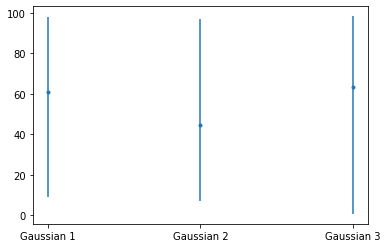

In [9]:
import matplotlib.pyplot as plt

mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]
ue3_instances = [
    samp.error_instance_at_upper_sigma(sigma=3.0) for samp in agg.values("samples")
]
le3_instances = [
    samp.error_instance_at_lower_sigma(sigma=3.0) for samp in agg.values("samples")
]

mp_centres = [instance.gaussian.centre for instance in mp_instances]
ue3_centres = [instance.gaussian.centre for instance in ue3_instances]
le3_centres = [instance.gaussian.centre for instance in le3_instances]

print(mp_centres)

plt.errorbar(
    x=["Gaussian 1", "Gaussian 2", "Gaussian 3"],
    y=mp_centres,
    marker=".",
    linestyle="",
    yerr=[le3_centres, ue3_centres],
)
plt.show()
plt.close()

# """
# These model-fits are consistent with a range range of global `centre` values. We could also show this by plotting the
# 1D PDF's of each model fit, using the library:
#
#  corner.py: https://corner.readthedocs.io/en/latest/
#
# (In built visualization for PDF's and non-linear searches is a future feature of PyAutoFit, but for now you'll have to
# use the libraries yourself!).
# """
#
# import corner
#
#
# samples = list(agg.values("samples"))
# print(samples[0].parameters_extract[2])
# pdf = corner.quantile(x=samples[0].parameters_extract[2], q=np.linspace(0.0, 1.0, 50), weights=samples[0].weights)
# print(pdf)
# # pdfs = [corner.quantile(x=samps.parameters, q=np.linspace(0.0, 1.0, 20), weights=samps.weights) for samps in samples]
# #print(pdfs)
#
# #plt.show()

So how might we estimate our global `centre`? We could take the mean of the data point and?
Alternatively, we could combine the samples into a joint set of samples and compute their joint PDF.

In [10]:
# TODO : RICH, can you make this so we can just add Samples objects together? E.g.:
# TODO : samples_joint = samples_0 + samples_1 + samples_2 or samples_joint = sum(agg.values("samples"))

samples_gen = agg.values("samples")

parameters_joint = []
log_likelihoods_joint = []
log_priors_joint = []
weights_joint = []
log_evidence = 0.0
total_samples = 0

for samples in agg.values("samples"):

    model = samples.model
    parameters_joint += samples.parameters
    log_likelihoods_joint += samples.log_likelihoods
    log_priors_joint += samples.log_priors
    weights_joint += samples.weights
    number_live_points = samples.number_live_points
    log_evidence += samples.log_evidence
    total_samples += samples.total_samples

# samples_joint = af.NestSamples(
#     model=model,
#     parameters=parameters_joint,
#     log_likelihoods=log_likelihoods_joint,
#     log_priors=log_priors_joint,
#     weights=weights_joint,
#     number_live_points=number_live_points,
#     log_evidence=log_evidence,
#     total_samples=total_samples,
# )
#
# print(samples_joint.median_pdf_instance.gaussian.centre)
# print(samples_joint.error_instance_at_upper_sigma(sigma=3.0).gaussian.centre)
# print(samples_joint.error_instance_at_lower_sigma(sigma=3.0).gaussian.centre)

Lets wrap up the tutorial. The methods used above to combine the results of different fits and estimate a global 
value of `centre` alongside estimates of its error. This is great, but it is unfortunately far from optimal for a
number of reasons:

 - When we combined results to estimate the global `centre`, we marginalized over the samples in 1D. This occured when 
 we took the mean of each `centre` estimate and errors and when using a joint PDF. If there are strong degeneracies
 between models parameters (which there is between `centre` and $I$) information on the covariance between these
 parameters is lost when computing the global `centre`, increasing the estimate uncertanties and potentially biasing 
 the estimated mean value.
 
 - In Bayesian inference it is important we define priors on all model parameters. By estimating the global `centre` 
 value after the model-fits were completed it is unclear what our prior on the global `centre` actually is, as we 
 never defined one! 

Fitting each dataset one-by-one also means that each model-fit fails to fully exploit all of the information we know 
about the global model. At the beginning of the tutorial, we stated that there was a single global value of `centre` 
that is the same across the dataset. However, each individual fit had its own `centre` value which was free to be 
different to the `centre` values used to fit the other datasets, in contradiction to the global model! 
 
The goodness of a model's fit to each dataset *should* inform us on how we the model fits the other datasets. If a 
model fits dataset 1 really well, but not datasets 2 and 3, the fit to dataset 1 should reflect this *during the 
non-linear search*! The fact we *know* there is only a single global `centre` value should be reflected in the 
non-linear search. 

If we could set up a model-fit that fitted all 3 datasets simultaneously using the same `centre` value for every 
likelihood evaluation, we would be able to fully exploit our knowledge of the global-model to produce an improved 
estimate of the global `centre`. This is the topic of the next tutorial.